In [23]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
#!pip install scikit-image
from skimage.transform import resize
import os
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#!pip install scikit-learn
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.applications import DenseNet121,VGG16,VGG19,ResNet50,ResNet152V2
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.initializers import HeUniform, VarianceScaling
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
#!pip install progressbar
import progressbar
#from pathlib import Path

In [9]:
def load_data(category, path, img_size=(32, 32)):
    #Variables
    
    corrupted={"count" : 0, "image_name" : [], "label" : []}
    Image_count = 0  
    Image_dir=[None]*len(category)
    
    for i in category.keys():
             Image_dir[category[i]]=glob.glob(path+i+"/*.png")        
        
    for idx, j in enumerate(Image_dir):
        for img in j:
            try:
                mpimg.imread(img)
            except:
                corrupted["count"] += 1
                corrupted["image_name"].append(img)
                corrupted["label"].append(idx)
            else:
                Image_count+=1
            
    for img, label in zip(corrupted['image_name'], corrupted["label"]):
            Image_dir[label].remove(img)
        
    Images = np.empty((Image_count, img_size[0], img_size[1], 3), dtype=np.float32)
    labels = np.empty((Image_count), dtype="int")
            
    c=0       
    for idx, k in enumerate(Image_dir):
            for img in k:
                Images[c] = resize(mpimg.imread(img), (img_size[0], img_size[1], 3), anti_aliasing=True)
                labels[c] = idx
                c+=1
                
    return Images, labels

In [10]:
path = 'D:/Data Analytics for Business/DAB Semester-3/DAB 304 - Healthcare Analytics/DAB 304 - Final Project material/archive (1)/curated_data/curated_data/'
category = {"1NonCOVID":0,"2COVID":1,"3CAP":2}
img_size = (224, 224)

In [11]:
X, y = load_data(category, path, img_size)

In [12]:
X.shape

(17067, 224, 224, 3)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify = y,
                                                    random_state=1)

In [26]:
# Data Augmentation
#data_augmentation = Sequential([
 #   layers.experimental.preprocessing.RandomFlip("horizontal"),
  #  layers.experimental.preprocessing.RandomRotation(0.05),
   # layers.experimental.preprocessing.RandomZoom(0.2)])

# To clear the session before every run
tf.keras.backend.clear_session()
    
def DenseNet121_model(img_size,
                      trainable=False,
                      semi_trainable=False,
                      hidden_layers=False,
                      num_units = 256,
                      dropout_rate = 0.5,
                      no_layers_trainable = 4,
                      optimizer=tf.keras.optimizers.Adam()):
    
    DenseNet = DenseNet121(weights='imagenet', include_top=False)
    DenseNet.trainable = trainable
    
    if semi_trainable == True:
        for layer in DenseNet.layers[:-no_layers_trainable]:
            layer.trainable=False

    Input_data = Input(shape=(img_size[0], img_size[1], 3))
    #x = data_augmentation(Input_data)
    x = preprocess_input(Input_data)
    x = DenseNet(x)
    x = Flatten()(x)
    if hidden_layers==True:
        x = Dense(num_units)(x)
        x = Dropout(dropout_rate)(x)
    Output = Dense(3, activation='softmax')(x)
    
    DenseNet121_model = Model(Input_data, Output)
    
    #Compiling the model (loss func, optimizer, metrics used)
    DenseNet121_model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer = optimizer,
        metrics = ["accuracy"]
    )

    return DenseNet121_model

DenseNet121_model = DenseNet121_model(img_size, 
                                      trainable = True, 
                                      hidden_layers = False, 
                                      num_units = 128,
                                      dropout_rate = 0.2,
                                      semi_trainable = True, 
                                      no_layers_trainable = 2)
DenseNet121_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_7 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1505

In [27]:
filepath = 'transfer_model.h5'
BATCH_SIZE = 128
lr = 0.01
OPTIMIZER = tf.keras.optimizers.Adam()
EPOCHS = 10

# Creating model checkpoint to save the best parameters based on validation accuracy
checkpoint = ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy',save_best_only=True, mode = 'max',verbose = 1)

# Fitting the model (training and validation phase in multiple epochs)
history = DenseNet121_model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    verbose = 2,
                    callbacks=[checkpoint]
                   )

Epoch 1/10
86/86 - 73s - loss: 2.8597 - accuracy: 0.6371 - val_loss: 0.8162 - val_accuracy: 0.5214

Epoch 00001: val_accuracy improved from -inf to 0.52142, saving model to transfer_model.h5
Epoch 2/10
86/86 - 54s - loss: 0.4743 - accuracy: 0.8096 - val_loss: 0.5130 - val_accuracy: 0.8330

Epoch 00002: val_accuracy improved from 0.52142 to 0.83303, saving model to transfer_model.h5
Epoch 3/10
86/86 - 55s - loss: 0.5013 - accuracy: 0.8075 - val_loss: 0.4089 - val_accuracy: 0.8451

Epoch 00003: val_accuracy improved from 0.83303 to 0.84511, saving model to transfer_model.h5
Epoch 4/10
86/86 - 56s - loss: 0.3748 - accuracy: 0.8556 - val_loss: 0.5380 - val_accuracy: 0.7272

Epoch 00004: val_accuracy did not improve from 0.84511
Epoch 5/10
86/86 - 56s - loss: 0.4765 - accuracy: 0.8285 - val_loss: 0.3241 - val_accuracy: 0.8707

Epoch 00005: val_accuracy improved from 0.84511 to 0.87074, saving model to transfer_model.h5
Epoch 6/10
86/86 - 57s - loss: 0.3522 - accuracy: 0.8632 - val_loss: 0.2

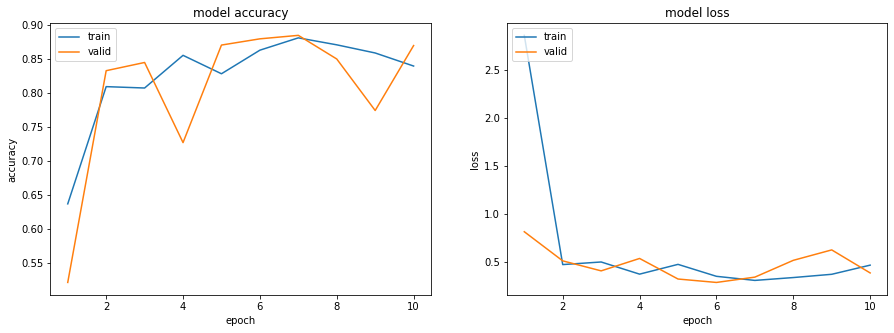

In [28]:
def plot_train_val_accuracy_n_loss(history, Range=2.0):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for ax, j in zip(axes, ['accuracy', 'loss']):
        # summarize history for accuracy and loss
        ax.plot(range(1, len(history.history[j]) + 1), history.history[j])
        ax.plot(range(1, len(history.history['val_'+j]) + 1), history.history['val_'+j])
        ax.set_title("model "+j)
        ax.set_ylabel(j)
        ax.set_xlabel('epoch')
        ax.set_xticks(np.arange(2,EPOCHS+1, Range))
        ax.legend(['train', 'valid'], loc='upper left')
    plt.show()
        
plot_train_val_accuracy_n_loss(history)

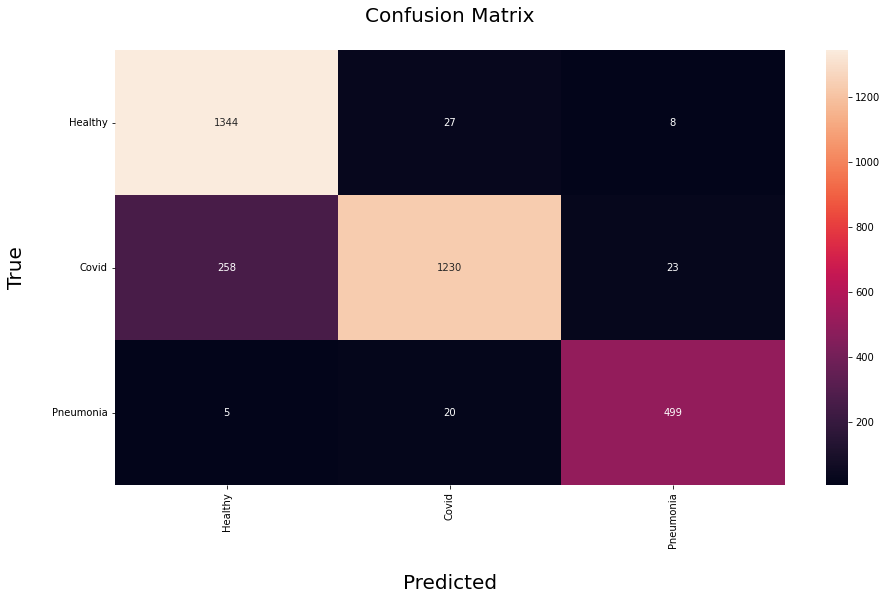

Test Accuracy:  0.9001171646162859
Test Precision:  0.9001171646162859
Test Recall:  0.9001171646162859
Test F1-Score:  0.9001171646162859


In [29]:
model = tf.keras.models.load_model("transfer_model.h5")

# Changinge one hot encoded data back to labels
y_pred = np.argmax(model.predict(X_test), axis=1) 
y_true = y_test

# Class Labels
class_names = ['Healthy', 'Covid', 'Pneumonia']

# Plotting Confusion matrix
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, class_names=class_names):
    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(15, 8))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('\nPredicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True\n', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix\n', fontsize=20)
    plt.show()

plot_confusion_matrix(cm)

print("Test Accuracy: ",accuracy_score(y_true, y_pred))
print("Test Precision: ",precision_score(y_true, y_pred, average='weighted')) 
print("Test Recall: ",recall_score(y_true, y_pred, average='weighted')) 
print("Test F1-Score: ",f1_score(y_true, y_pred, average='weighted')) 